In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

warnings.filterwarnings("ignore", category=DeprecationWarning)
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.utils import algorithm_globals
# from qiskit_ibm_provider import IBMProvider
# from qiskit_ibm_runtime import QiskitRuntimeService, Session

import qiskit.primitives
import qiskit_ibm_runtime

In [2]:
def get_dataset(start, stop, columns):
    x_to_return = pd.DataFrame(iris.data[start:stop])
    y_to_return = pd.Series(iris.target[start:stop])

    x_to_return.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

    x_to_return = x_to_return.loc[:, columns]

    x_to_return = StandardScaler().fit_transform(x_to_return)

    return *train_test_split(
        x_to_return, y_to_return, test_size=0.3, random_state=1, stratify=y_to_return), x_to_return, y_to_return

In [3]:
seed = 1
algorithm_globals.random_seed = seed

iris = datasets.load_iris()
sns.set()

In [ ]:
sns.pairplot(pd.DataFrame(
    np.vstack([iris.data.T, iris.target]).T,
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'variety']),
    hue="variety", palette="tab10"
)

In [4]:
experiment_columns = ['petal_length', 'petal_width']

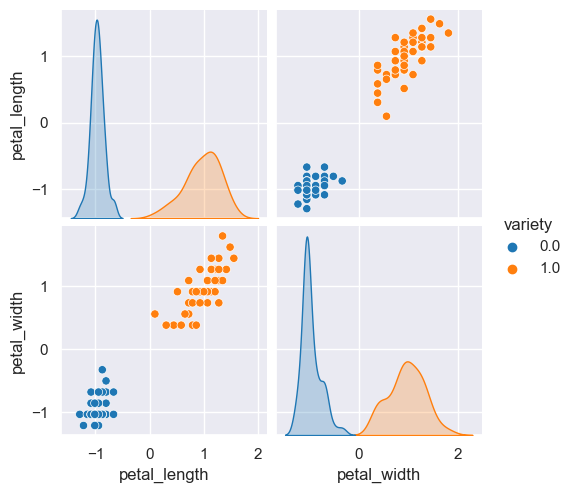

In [5]:
X_train, X_test, y_train, y_test, X, y = get_dataset(0, 100, experiment_columns)
sns.pairplot(
    pd.DataFrame(
        np.vstack([X.T, y]).T,
        columns=experiment_columns + ["variety"]
    ),
    hue="variety", palette="tab10"
)

Start of experimenting

In [6]:
svm = SVC(kernel='linear', C=1.0, random_state=seed)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
easy_separable_data_acc = accuracy_score(y_test, y_pred)

print(f'SVM accuracy easy separable data: {easy_separable_data_acc}')

SVM accuracy easy separable data: 1.0


In [7]:
X_train, X_test, y_train, y_test, _, _ = get_dataset(0, 100, experiment_columns)

kernel = FidelityQuantumKernel(fidelity=ComputeUncompute(sampler=qiskit.primitives.Sampler()),
                               feature_map=PauliFeatureMap(feature_dimension=2, reps=1, paulis=['Z']))
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)
qsvc = SVC(kernel="precomputed")
qsvc.fit(matrix_train, y_train)
easy_separable_data_qacc = qsvc.score(matrix_test, y_test)

print(f'QSVM accuracy easy separable data: {easy_separable_data_qacc}')

QSVM accuracy easy separable data: 1.0


In [8]:
# just using ZFeatureMap class but not PauliFeatureMap

X_train, X_test, y_train, y_test, _, _ = get_dataset(0, 100, experiment_columns)

kernel = FidelityQuantumKernel(fidelity=ComputeUncompute(sampler=qiskit.primitives.Sampler()),
                               feature_map=ZFeatureMap(feature_dimension=2, reps=1, insert_barriers=True))
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)
qsvc = SVC(kernel="precomputed")
qsvc.fit(matrix_train, y_train)
easy_separable_data_qacc_feature_map = qsvc.score(matrix_test, y_test)

print(f'QSVM accuracy easy separable data ZFeatureMap: {easy_separable_data_qacc_feature_map}')

QSVM accuracy easy separable data ZFeatureMap: 1.0


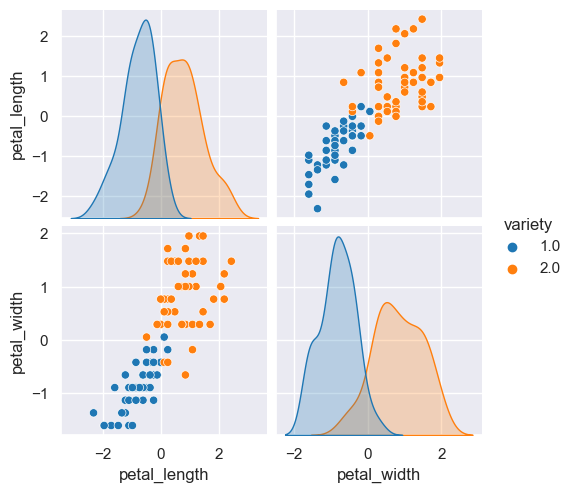

In [9]:
X_train, X_test, y_train, y_test, X, y = get_dataset(50, 150, experiment_columns)
sns.pairplot(
    pd.DataFrame(
        np.vstack([X.T, y]).T,
        columns=experiment_columns + ["variety"]
    ),
    hue="variety", palette="tab10"
)

In [10]:
svm = SVC(kernel='linear', C=1.0, random_state=seed)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
not_easy_separable_data_acc = accuracy_score(y_test, y_pred)

print(f'SVM accuracy NOT easy separable data: {not_easy_separable_data_acc}')

SVM accuracy NOT easy separable data: 0.9666666666666667


In [11]:
kernel = FidelityQuantumKernel(
    fidelity=ComputeUncompute(sampler=qiskit.primitives.Sampler()),
    feature_map=PauliFeatureMap(feature_dimension=2, reps=1, paulis=["Z"])
)
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)
qsvc = SVC(kernel="precomputed")
qsvc.fit(matrix_train, y_train)
not_easy_separable_data_qacc = qsvc.score(matrix_test, y_test)

print(f'QSVM accuracy NOT easy separable data: {not_easy_separable_data_qacc}')

QSVM accuracy NOT easy separable data: 0.8333333333333334


In [12]:
# just using ZFeatureMap class but not PauliFeatureMap

kernel = FidelityQuantumKernel(fidelity=ComputeUncompute(sampler=qiskit.primitives.Sampler()),
                               feature_map=ZFeatureMap(feature_dimension=2, reps=1, insert_barriers=True))
simulator_matrix_train = kernel.evaluate(x_vec=X_train)
simulator_matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)
qsvc = SVC(kernel="precomputed")
qsvc.fit(simulator_matrix_train, y_train)
not_easy_separable_data_qacc_feature_map = qsvc.score(simulator_matrix_test, y_test)

print(f'QSVM accuracy NOT easy separable data ZFeatureMap: {not_easy_separable_data_qacc_feature_map}')

QSVM accuracy NOT easy separable data ZFeatureMap: 0.8333333333333334


Start of computing on real quantum computers

In [13]:
from qiskit import IBMQ

# IBMQ.delete_accounts()

IBMQ.save_account(
    'da75620000b0ccd1e3c7c7dfeb278c7734603799ee9b57a64a31499d1c9c1779db6c294573ec8f7f5d5bf869260f28ecef929a2b70eee8e88dc3a717405c8eac')

provider = IBMQ.load_account()

for b in provider.backends():
    print(b.status().to_dict() | {'n_qubits': b.configuration().n_qubits})

{'backend_name': 'ibmq_qasm_simulator', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active', 'n_qubits': 32}
{'backend_name': 'ibmq_lima', 'backend_version': '1.0.49', 'operational': True, 'pending_jobs': 90, 'status_msg': 'active', 'n_qubits': 5}
{'backend_name': 'ibmq_belem', 'backend_version': '1.2.9', 'operational': True, 'pending_jobs': 17, 'status_msg': 'active', 'n_qubits': 5}
{'backend_name': 'ibmq_quito', 'backend_version': '1.1.42', 'operational': True, 'pending_jobs': 23, 'status_msg': 'active', 'n_qubits': 5}
{'backend_name': 'simulator_statevector', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active', 'n_qubits': 32}
{'backend_name': 'simulator_mps', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active', 'n_qubits': 100}
{'backend_name': 'simulator_extended_stabilizer', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 0, 'status_msg': '

In [14]:
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q')
num_qubits = 1

from qiskit.providers.ibmq import least_busy

possible_devices = provider.backends(
    filters=lambda x: x.configuration().n_qubits >= num_qubits and x.configuration().simulator == False)

backend = least_busy(possible_devices)
print(type(backend))

<class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'>


In [24]:
str(backend)

'ibmq_lima'

In [19]:
X_train, X_test, y_train, y_test, X, y = get_dataset(0, 100, experiment_columns)

kernel = FidelityQuantumKernel(
    fidelity=ComputeUncompute(sampler=qiskit_ibm_runtime.Sampler(session=str(backend))),
    feature_map=PauliFeatureMap(feature_dimension=2, reps=1, paulis=["Z"])
)
real_quantum_computer_matrix_train = kernel.evaluate(x_vec=X_train)
real_quantum_computer_matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)
qsvc = SVC(kernel="precomputed")
qsvc.fit(real_quantum_computer_matrix_train, y_train)
easy_separable_data_qacc_real_comp = qsvc.score(real_quantum_computer_matrix_test, y_test)

print(f'QSVM accuracy easy separable data on real computer: {easy_separable_data_qacc_real_comp}')

QSVM accuracy easy separable data on real computer: 1.0


In [20]:
simulator_matrix_train - real_quantum_computer_matrix_train

array([[-0.01469532, -0.06174242, -0.22691873, ..., -0.78304173,
         0.46989853, -0.35912665],
       [-0.06174242, -0.01711584, -0.05140369, ..., -0.09346328,
        -0.64013539, -0.02740687],
       [-0.22691873, -0.05140369, -0.01104843, ..., -0.34635921,
         0.14654978, -0.75332742],
       ...,
       [-0.78304173, -0.09346328, -0.34635921, ..., -0.01782917,
        -0.18734161, -0.92315647],
       [ 0.46989853, -0.64013539,  0.14654978, ..., -0.18734161,
        -0.01691947,  0.20920868],
       [-0.35912665, -0.02740687, -0.75332742, ..., -0.92315647,
         0.20920868, -0.01209979]])

In [21]:
(simulator_matrix_train - real_quantum_computer_matrix_train).sum() / (
        simulator_matrix_train.shape[0] * simulator_matrix_train.shape[1])

-0.1472982939663085

In [15]:
X_train, X_test, y_train, y_test, _, _ = get_dataset(50, 150, experiment_columns)

kernel = FidelityQuantumKernel(fidelity=ComputeUncompute(sampler=qiskit_ibm_runtime.Sampler(session=str(backend))),
                               feature_map=PauliFeatureMap(feature_dimension=2, reps=1, paulis=["Z"]))
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)
qsvc = SVC(kernel="precomputed")
qsvc.fit(matrix_train, y_train)
not_easy_separable_data_qacc_real_comp = qsvc.score(matrix_test, y_test)

print(f'QSVM accuracy NOT easy separable data on real computer: {not_easy_separable_data_qacc_real_comp}')

QSVM accuracy NOT easy separable data on real computer: 0.8333333333333334


In [26]:
simulator_matrix_train

array([[1.        , 0.03807804, 0.73812397, ..., 0.16581711, 0.70158463,
        0.63607321],
       [0.03807804, 1.        , 0.00120629, ..., 0.00315802, 0.25031029,
        0.06963123],
       [0.73812397, 0.00120629, 1.        , ..., 0.63607321, 0.2948333 ,
        0.20928834],
       ...,
       [0.16581711, 0.00315802, 0.63607321, ..., 1.        , 0.01791385,
        0.01674998],
       [0.70158463, 0.25031029, 0.2948333 , ..., 0.01791385, 1.        ,
        0.43662018],
       [0.63607321, 0.06963123, 0.20928834, ..., 0.01674998, 0.43662018,
        1.        ]])

In [27]:
matrix_train

array([[ 1.01831746,  0.04157851,  0.74152394, ...,  0.16891243,
         0.73524364,  0.59210796],
       [ 0.04157851,  1.02223097,  0.00260692, ..., -0.00381768,
         0.26091996,  0.05360773],
       [ 0.74152394,  0.00260692,  1.02054544, ...,  0.6505794 ,
         0.31270858,  0.19187164],
       ...,
       [ 0.16891243, -0.00381768,  0.6505794 , ...,  1.02567572,
         0.02204727,  0.03060888],
       [ 0.73524364,  0.26091996,  0.31270858, ...,  0.02204727,
         1.02210309,  0.41852147],
       [ 0.59210796,  0.05360773,  0.19187164, ...,  0.03060888,
         0.41852147,  1.03515875]])

In [28]:
(simulator_matrix_train - matrix_train).sum() / (simulator_matrix_train.shape[0] * simulator_matrix_train.shape[1])

-0.0026791418172254643